In [1]:
import os
import findspark

In [2]:
findspark.init()

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, explode, regexp_replace, split, when, size, array_contains, isnan, when, count, array, reverse, udf, unix_timestamp, from_unixtime, date_format, format_number, length, first, array_contains, expr
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis, skew
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import math
import folium
import pickle
import random
from itertools import chain
from urllib.parse import urlparse

### Spark

In [4]:
spark_url = 'local'
spark = SparkSession.builder\
        .master(spark_url)\
        .appName('Project')\
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
        .getOrCreate()
spark.conf.set("spark.sql.csv.parser.multiLine", "true")

In [5]:
# path = '/content/drive/MyDrive/traffy/bangkok_traffy.csv'
path = 'bangkok_traffy.csv'
df = spark.read.option("multiLine", "true").csv(path, header=True, inferSchema=True)
df.show(5)

+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------+--------------------+--------------------+--------------+----+------------+--------------------+
|  ticket_id|               type|        organization|             comment|               photo|         photo_after|            coords|             address|subdistrict|district|            province|           timestamp|         state|star|count_reopen|       last_activity|
+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------+--------------------+--------------------+--------------+----+------------+--------------------+
|2021-9LHDM6|                 {}|                null|            ไม่มีภาพ|https://storage.g...|                null|100.48661,13.79386|1867 จรัญสนิทวงศ์...|    บางพลัด| บางพล

In [6]:
use_col = ['type', 'organization', 'subdistrict', 'coords', 'district', 'province', 'state', 'star', 'timestamp', 'last_activity']
df = df[use_col]

Check numbers of null in the table

In [7]:
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----+------------+-----------+------+--------+--------+-----+------+---------+-------------+
|type|organization|subdistrict|coords|district|province|state|  star|timestamp|last_activity|
+----+------------+-----------+------+--------+--------+-----+------+---------+-------------+
|1550|        2640|       2089|  2019|    2092|    2393| 2026|164087|     2233|         2558|
+----+------------+-----------+------+--------+--------+-----+------+---------+-------------+



Drop any rows from the dataframe that contain at least one missing value in any column

In [8]:
df = df.dropna('any')
df.show(5)

+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|               type|        organization|subdistrict|            coords|district|     province|    state|star|           timestamp|       last_activity|
+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|{น้ำท่วม,ร้องเรียน}|เขตประเวศ,ฝ่ายโยธ...|    หนองบอน|100.66709,13.67891|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:...|2022-06-21 08:21:...|
|      {น้ำท่วม,ถนน}|เขตลาดพร้าว,ฝ่ายโ...|   ลาดพร้าว|100.59165,13.82280|ลาดพร้าว|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-09 12:29:...|2022-08-12 07:18:...|
|                 {}|            เขตดุสิต|      ดุสิต|100.50848,13.77832|   ดุสิต|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-17 08:46:...|2022-06-01 03:16:...|
|        {ความสะอาด}|เขตประเวศ,ฝ่ายเทศ...|    หนองบอน|100.64690,13.67083|  ป

Clean organization data

In [9]:
df = df.withColumn('organization', split(df['organization'], ','))

df = df.withColumn('organization', expr('filter(organization, item -> item not LIKE \'เขต%\')'))
df = df.filter(size('organization') > 0)
df.show(5)

+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|               type|        organization|subdistrict|            coords|district|     province|    state|star|           timestamp|       last_activity|
+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|{น้ำท่วม,ร้องเรียน}|[ฝ่ายโยธา เขตประเวศ]|    หนองบอน|100.66709,13.67891|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:...|2022-06-21 08:21:...|
|      {น้ำท่วม,ถนน}|[ฝ่ายโยธา เขตลาดพ...|   ลาดพร้าว|100.59165,13.82280|ลาดพร้าว|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-09 12:29:...|2022-08-12 07:18:...|
|        {ความสะอาด}|[ฝ่ายเทศกิจ เขตปร...|    หนองบอน|100.64690,13.67083|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   2|2021-12-18 14:50:...|2022-06-14 07:36:...|
|                 {}|[ฝ่ายเทศกิจ เขตปร...|     ประเวศ|100.65617,13.72812|  ป

In [10]:
df = df.withColumn('organization', df['organization'].getItem(0))
df.show(5)

+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|               type|        organization|subdistrict|            coords|district|     province|    state|star|           timestamp|       last_activity|
+-------------------+--------------------+-----------+------------------+--------+-------------+---------+----+--------------------+--------------------+
|{น้ำท่วม,ร้องเรียน}|  ฝ่ายโยธา เขตประเวศ|    หนองบอน|100.66709,13.67891|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:...|2022-06-21 08:21:...|
|      {น้ำท่วม,ถนน}|ฝ่ายโยธา เขตลาดพร้าว|   ลาดพร้าว|100.59165,13.82280|ลาดพร้าว|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-09 12:29:...|2022-08-12 07:18:...|
|        {ความสะอาด}|ฝ่ายเทศกิจ เขตประเวศ|    หนองบอน|100.64690,13.67083|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   2|2021-12-18 14:50:...|2022-06-14 07:36:...|
|                 {}|ฝ่ายเทศกิจ เขตประเวศ|     ประเวศ|100.65617,13.72812|  ป

In [11]:
df.groupBy(col('province')).count().show()

+--------------------+-----+
|            province|count|
+--------------------+-----+
|              บางรัก|    1|
|               พญาไท|    1|
|           นครสวรรค์|    1|
|            สะพานสูง|    1|
|       กรุงเทพมหานคร|93158|
|             ปทุมวัน|    1|
|               ลำพูน|    1|
|         สมุทรปราการ|   14|
|             นนทบุรี|    3|
|             จตุจักร|    1|
|      จังหวัดนนทบุรี|    1|
|            ปทุมธานี|    1|
|              ภูเก็ต|    1|
|จังหวัดกรุงเทพมหานคร|  954|
+--------------------+-----+



In [12]:
df = df.filter((df['province'] == 'กรุงเทพมหานคร') | (df['province'] == 'จังหวัดกรุงเทพมหานคร'))
df.groupBy(col('province')).count().show()

+--------------------+-----+
|            province|count|
+--------------------+-----+
|       กรุงเทพมหานคร|93158|
|จังหวัดกรุงเทพมหานคร|  954|
+--------------------+-----+



In [13]:
df.toPandas().to_csv('./chadchart.csv')

Clean [type, coords, timestamp, last_activity] 

In [14]:
df = df.filter(df.state == 'เสร็จสิ้น')

# change type to list
df = df.withColumn("type", split(regexp_replace("type", "[{}]", ""), ","))
df = df.dropna(how='all', subset=['type'])

# change coords to pair and swap them into format [latitude, longtitude]
flatten = udf(lambda x: list(chain.from_iterable(x)), ArrayType(StringType()))
df = df.withColumn('coords', array(reverse(split(df.coords, ','))))
df = df.withColumn('coords', flatten('coords'))

# change timestamp and last_activity
df = df.withColumn('timestamp', from_unixtime(unix_timestamp(col('timestamp'), 'yyyy-MM-dd HH:mm')))
df = df.withColumn('last_activity', from_unixtime(unix_timestamp(col('last_activity'), 'yyyy-MM-dd HH:mm')))
df = df.withColumn('time_diff', (unix_timestamp(col('last_activity')) - unix_timestamp(col('timestamp'))) / 86400)
df = df.withColumn('time_diff', format_number(col('time_diff'), 0))
df = df.withColumn("time_diff", col("time_diff").cast("integer"))
df.show(5)

+--------------------+--------------------+-----------+--------------------+--------+-------------+---------+----+-------------------+-------------------+---------+
|                type|        organization|subdistrict|              coords|district|     province|    state|star|          timestamp|      last_activity|time_diff|
+--------------------+--------------------+-----------+--------------------+--------+-------------+---------+----+-------------------+-------------------+---------+
|[น้ำท่วม, ร้องเรียน]|  ฝ่ายโยธา เขตประเวศ|    หนองบอน|[13.67891, 100.66...|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:00|2022-06-21 08:21:00|      275|
|      [น้ำท่วม, ถนน]|ฝ่ายโยธา เขตลาดพร้าว|   ลาดพร้าว|[13.82280, 100.59...|ลาดพร้าว|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-09 12:29:00|2022-08-12 07:18:00|      246|
|         [ความสะอาด]|ฝ่ายเทศกิจ เขตประเวศ|    หนองบอน|[13.67083, 100.64...|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   2|2021-12-18 14:50:00|2022-06-14 07:36:00|      178|
|         

In [16]:
df = df.withColumn('type', explode(df['type']))
df = df.filter("type != ''")

df = df.withColumn("latitude", col("coords")[0]) \
       .withColumn("longitude", col("coords")[1]) \
       .drop("coords")
df = df.withColumn("latitude", col("latitude").cast('double'))
df = df.withColumn("longitude", col("longitude").cast('double'))
df.show(5)

+-----------+--------------------+------------+--------+-------------+---------+----+-------------------+-------------------+---------+--------+---------+
|       type|        organization| subdistrict|district|     province|    state|star|          timestamp|      last_activity|time_diff|latitude|longitude|
+-----------+--------------------+------------+--------+-------------+---------+----+-------------------+-------------------+---------+--------+---------+
|    น้ำท่วม|กลุ่มกรุงธนเหนือ ...|     หนองบอน|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:00|2022-06-21 08:21:00|      275|13.67891|100.66709|
|  ร้องเรียน|กลุ่มกรุงธนเหนือ ...|     หนองบอน|  ประเวศ|กรุงเทพมหานคร|เสร็จสิ้น|   4|2021-09-19 14:56:00|2022-06-21 08:21:00|      275|13.67891|100.66709|
|    น้ำท่วม|ฝ่ายโยธา เขตลาดพร้าว|    ลาดพร้าว|ลาดพร้าว|กรุงเทพมหานคร|เสร็จสิ้น|   5|2021-12-09 12:29:00|2022-08-12 07:18:00|      246| 13.8228|100.59165|
|        ถนน|ฝ่ายโยธา เขตลาดพร้าว|    ลาดพร้าว|ลาดพร้าว|กรุงเทพมหานคร|

In [17]:
drop_list = ['type', 'organization', 'subdistrict', 'district', 'province', 'state', 'star', 'timestamp', 'last_activity', 'time_diff', 'latitude', 'longitude']
for e in drop_list:
    df = df.dropna(how='all', subset=[e])

In [18]:
df.groupBy(col('star')).count().show()

+----+-----+
|star|count|
+----+-----+
|   3| 9957|
|   5|45825|
|   1|12931|
|   4|20647|
|   2| 4363|
+----+-----+



### ML

Train classification with RandomForestClassifier

In [19]:
def train_random_forest(df, label_col, numeric_col, nominal_col, seed):
    dummy_df = pd.get_dummies(df[nominal_col], drop_first=True) 
    tw_dummy_df = pd.concat([df, dummy_df], axis=1)
    tw_dummy_df = tw_dummy_df.drop(nominal_col, axis=1)

    y = tw_dummy_df.pop('star')
    X = tw_dummy_df
    X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=seed)

    rfc=RandomForestClassifier(random_state=seed)
    param_grid = { 
        'criterion':['gini','entropy'],
        'max_depth': [2,3,6],
        'min_samples_leaf':[2,5,10],
        'n_estimators':[100,200],
        'random_state': [112]
    }

    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    CV_rfc.fit(X_train, y_train)
    model = CV_rfc.best_estimator_
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    return CV_rfc, model, X_train, X_test, y_train, y_test, y_pred

In [20]:
seed = 112

numeric_col = ['time_diff']
nominal_col = ['type', 'star', 'subdistrict', 'district', 'organization']
label_col = ['star']
df_select = df[numeric_col + nominal_col]
df_select = df_select.toPandas()
df_select = df_select.replace({"star": {"1": 1, "2": 2, "3": 3, "4": 4, "5": 5}})

numeric_use_col = ['time_diff']
nominal_use_col = ['type', 'subdistrict', 'district', 'organization']

CV_rfc, model, X_train, X_test, y_train, y_test, y_pred = train_random_forest(df_select, label_col, numeric_use_col, nominal_use_col, seed) 

Accuracy: 0.49720809474695027


In [22]:
# mlflow
mlflow.set_tracking_uri("http://localhost:5000")
experiment_name = "traffy_predict_star"
mlflow.set_experiment(experiment_name)
best_params = CV_rfc.best_params_
accuracy = accuracy_score(y_test, y_pred)
with mlflow.start_run():
    # log param
    mlflow.log_param('criterion', best_params['criterion'])
    mlflow.log_param('max_depth', best_params['max_depth'])
    mlflow.log_param('min_samples_leaf', best_params['min_samples_leaf'])
    mlflow.log_param('n_estimators', best_params['n_estimators'])
    mlflow.log_param('random_state', best_params['random_state'])
    # log metric
    mlflow.log_metric('accuracy', accuracy)
    # save model
    mlflow.sklearn.save_model(model, 'random_forest_model_classification')

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model, "model", registered_model_name="random_forest_model_classification")
    else:
        mlflow.sklearn.log_model(model, "model")
        
    mlflow.end_run()

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'random_forest_model_classification'.
2023/05/19 09:52:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_model_classification, version 1
Created version '1' of model 'random_forest_model_classification'.


In [23]:
unique_elements, counts = np.unique(y_pred, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

4: 293
5: 27824


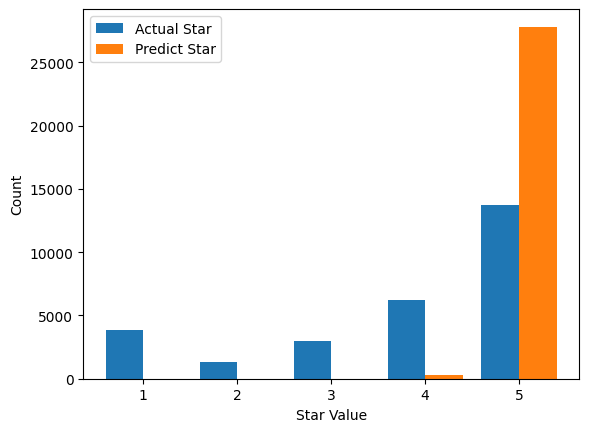

In [24]:
actual_star_counts = y_test.value_counts().sort_index()
fig, ax = plt.subplots()

ax.bar(actual_star_counts.index-0.2, actual_star_counts.values, width=0.4, label='Actual Star')
ax.bar(unique_elements+0.2, counts, width=0.4, label='Predict Star')
ax.set_xlabel('Star Value')
ax.set_ylabel('Count')
ax.legend()
plt.show()

In [29]:
df_use = df.filter((df['district'] != 'คลองสาน') \
    & (df['subdistrict'] != 'กระทุ่มราย') \
    & (df['type'] != 'PM2.5') \
    & (df['organization'] != 'เขตบางกะปิ'))
df_combined = df_use.toPandas().copy()
df_combined['combined'] = df_combined.apply(lambda x: list([x['subdistrict'],x['district'],x['organization']]), axis=1)
df_combined = df_combined[['type', 'time_diff', 'combined']]
df_combined

,type,time_diff,combined
0,น้ำท่วม,275,"[หนองบอน, ประเวศ, ฝ่ายโยธา เขตประเวศ]"
1,ร้องเรียน,275,"[หนองบอน, ประเวศ, ฝ่ายโยธา เขตประเวศ]"
2,น้ำท่วม,246,"[ลาดพร้าว, ลาดพร้าว, ฝ่ายโยธา เขตลาดพร้าว]"
3,ถนน,246,"[ลาดพร้าว, ลาดพร้าว, ฝ่ายโยธา เขตลาดพร้าว]"
4,ความสะอาด,178,"[หนองบอน, ประเวศ, ฝ่ายเทศกิจ เขตประเวศ]"
...,...,...,...
92129,ทางเท้า,1,"[ถนนพญาไท, ราชเทวี, ฝ่ายเทศกิจ เขตราชเทวี]"
92130,กีดขวาง,0,"[พระโขนง, คลองเตย, ฝ่ายเทศกิจ เขตคลองเตย]"
92131,กีดขวาง,0,"[พระโขนง, คลองเตย, ฝ่ายเทศกิจ เขตคลองเตย]"
92132,ถนน,0,"[พระโขนง, คลองเตย, ฝ่ายเทศกิจ เขตคลองเตย]"


In [30]:
new_df = pd.DataFrame()
for column in df_combined.columns:
    if column == 'combined':
        new_df[column] = df_combined[column]
    else:
        new_df[column] = df_combined[column].sample(frac=1).reset_index(drop=True)

random_sample = new_df.sample(n=10000, random_state=112)
random_sample[['subdistrict', 'district', 'organization']] = random_sample['combined'].apply(pd.Series)
random_sample_used = random_sample[['type','time_diff', 'subdistrict', 'district', 'organization']]
random_sample_used

,type,time_diff,subdistrict,district,organization
44569,ความปลอดภัย,8,บางแคเหนือ,บางแค,สน.เพชรเกษม
63201,ความปลอดภัย,196,คลองเตยเหนือ,วัฒนา,กองระบบคลอง สำนักการระบายน้ำ
22980,ถนน,208,พระโขนง,คลองเตย,ฝ่ายเทศกิจ เขตคลองเตย
45921,คลอง,36,ห้วยขวาง,ห้วยขวาง,ฝ่ายสิ่งแวดล้อมฯ เขตห้วยขวาง
70128,ถนน,1,นวมินทร์,บึงกุ่ม,ฝ่ายเทศกิจ เขตบึงกุ่ม
...,...,...,...,...,...
16078,น้ำท่วม,2,แสมดำ,บางขุนเทียน,ผอ.เขตบางขุนเทียน (นางภัสรา)
80490,ถนน,203,ดาวคะนอง,ธนบุรี,สำนักการโยธา กทม.
47270,กีดขวาง,98,บ้านช่างหล่อ,บางกอกน้อย,ฝ่ายโยธา เขตบางกอกน้อย
9988,คลอง,176,ถนนพญาไท,ราชเทวี,สำนักการจราจรและขนส่ง กรุงเทพมหานคร (สจส.)


In [31]:
def predict_each(data, model, X_test):
    test_dummy_df = pd.DataFrame(0, index=[0], columns=X_test.columns)
    for e in ['type', 'time_diff', 'subdistrict', 'district', 'organization']:
        if isinstance(data[e], str):
            string_value = e + '_' + data[e]
            test_dummy_df.loc[0, string_value] = 1
    predicted_star = model.predict(test_dummy_df)
    return predicted_star[0]

random_sample_used['predicted_star'] = random_sample_used.apply(lambda row: predict_each(row, model, X_test), axis=1)
random_sample_used

,type,time_diff,subdistrict,district,organization,predicted_star
44569,ความปลอดภัย,8,บางแคเหนือ,บางแค,สน.เพชรเกษม,5
63201,ความปลอดภัย,196,คลองเตยเหนือ,วัฒนา,กองระบบคลอง สำนักการระบายน้ำ,5
22980,ถนน,208,พระโขนง,คลองเตย,ฝ่ายเทศกิจ เขตคลองเตย,5
45921,คลอง,36,ห้วยขวาง,ห้วยขวาง,ฝ่ายสิ่งแวดล้อมฯ เขตห้วยขวาง,5
70128,ถนน,1,นวมินทร์,บึงกุ่ม,ฝ่ายเทศกิจ เขตบึงกุ่ม,4
...,...,...,...,...,...,...
16078,น้ำท่วม,2,แสมดำ,บางขุนเทียน,ผอ.เขตบางขุนเทียน (นางภัสรา),5
80490,ถนน,203,ดาวคะนอง,ธนบุรี,สำนักการโยธา กทม.,5
47270,กีดขวาง,98,บ้านช่างหล่อ,บางกอกน้อย,ฝ่ายโยธา เขตบางกอกน้อย,5
9988,คลอง,176,ถนนพญาไท,ราชเทวี,สำนักการจราจรและขนส่ง กรุงเทพมหานคร (สจส.),5


In [32]:
random_sample_used.groupby(['predicted_star'])['predicted_star'].count()

predicted_star
4      99
5    9901
Name: predicted_star, dtype: int64

In [33]:
random_sample_used.to_csv('./result.csv')

### RESTful API

In [35]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/', methods=['GET'])
def hello():
    return "Go to predict at /predict"

@app.route('/predict', methods=['POST'])
def predict_star():
    data = request.json
    test_dummy_df = pd.DataFrame(0, index=[0], columns=X_test.columns)
    
    for e in data:
        if isinstance(data[e], str):
            string_value = e + '_' + data[e]
            test_dummy_df.loc[0, string_value] = 1
    
    predicted_star = model.predict(test_dummy_df)
    
    response = {'predicted_star': int(predicted_star[0])}
    return jsonify(response)

if __name__ == '__main__':
    app.run(host="localhost", port=8000)

 * Tip: There are .env or .flaskenv files present. Do "pip install python-dotenv" to use them.


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:8000
Press CTRL+C to quit
127.0.0.1 - - [19/May/2023 10:44:45] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2023 10:44:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2023 10:44:57] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2023 10:45:06] "POST /predict HTTP/1.1" 200 -


In [ ]:
spark.stop()

ConnectionRefusedError: ignored